# Gaussian Process Regression
## Synthetic Examples

In this lab, we'll explore GP priors, as well as regressing on some synthetic data.  For this lab, we'll only use numpy and matplotlib, underscoring the apparent simplicity of this approach to modelling.  

### GP Priors

As a conceptual example, let's again imagine that we're predicting the (log-)concentration of gold in the surface layer of a landscape (although you could envision this as any other spatial interpolation task that you might find more compelling).  To begin, let's define an index set $X^*$, or locations at which we'd like to evaluate a model.  For simplicity's sake, let's say that our domain is the interval $[-1,1]$, and that we'd like to evaluate this model at $m^*=100$ evenly spaced points.  Then we can define



In [60]:
import numpy as np

m_star = 100
X_star = np.linspace(-1,1,m_star).reshape(-1,1)

Next, create a function that produces the covariance matrix
$$
K(X,X') = \begin{bmatrix} k(x_1,x_1) & k(x_1,x_2) & \cdots & k(x_1,x_m) \\
                          k(x_2,x_1) & k(x_2,x_2) & \cdots & k(x_2,x_m) \\
                          \vdots     & \vdots     & \ddots & \vdots     \\
                          k(x_m,x_1) & k(x_m,x_2) & \cdots & k(x_m,x_m) \end{bmatrix}
$$
for covariance function
$$
k(x,x') = \sigma^2 \mathrm{exp}\left( - \frac{1}{2} \frac{|x-x'|^2}{\ell^2} \right).
$$
This functions should not only accept vectors $X$ and $X'$, but should also accept hyperparameters $\sigma^2$ and $\ell$.  

In [61]:
from scipy.spatial import distance_matrix # You might find this useful for a vectorized implementation

def k(x,xp,l=0.3,sigma2=10.0):
    # Do stuff here
    K = distance_matrix(x,xp)
    k = sigma2*np.exp(-1/2*np.abs(K)**2/(l**2))
    return k # CHANGE ME

K = k(X_star,X_star)
print((K))

[[1.00000000e+01 9.97735226e+00 9.90971633e+00 ... 5.43264923e-09
  3.49137328e-09 2.23363144e-09]
 [9.97735226e+00 1.00000000e+01 9.97735226e+00 ... 8.41506855e-09
  5.43264923e-09 3.49137328e-09]
 [9.90971633e+00 9.97735226e+00 1.00000000e+01 ... 1.29758036e-08
  8.41506855e-09 5.43264923e-09]
 ...
 [5.43264923e-09 8.41506855e-09 1.29758036e-08 ... 1.00000000e+01
  9.97735226e+00 9.90971633e+00]
 [3.49137328e-09 5.43264923e-09 8.41506855e-09 ... 9.97735226e+00
  1.00000000e+01 9.97735226e+00]
 [2.23363144e-09 3.49137328e-09 5.43264923e-09 ... 9.90971633e+00
  9.97735226e+00 1.00000000e+01]]


Evaluate your covariance function on $X^*$, which should create a $m^* \times m^*$ symmetric matrix.  The diagonal of this covariance matrix contains the so-called 'marginal' variance at each point: the *a prior* uncertainty in the function value.  Given this covariance function, you can use the following function to produce a nice plot of the resulting GP.

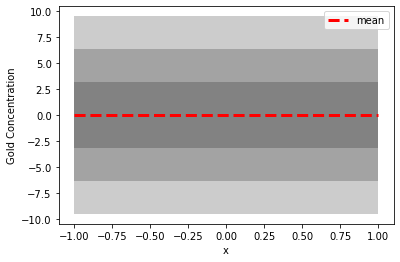

In [62]:
import matplotlib.pyplot as plt
def gp_plot(X,m,K):
    plt.plot(X_star.squeeze(),m.squeeze(),'r--',lw=3.0,label='mean')
    plt.fill_between(X_star.squeeze(),m.squeeze()-3*np.sqrt(np.diagonal(K)),m.squeeze()+3*np.sqrt(np.diagonal(K)),facecolor='k',alpha=0.2)
    plt.fill_between(X_star.squeeze(),m.squeeze()-2*np.sqrt(np.diagonal(K)),m.squeeze()+2*np.sqrt(np.diagonal(K)),facecolor='k',alpha=0.2)
    plt.fill_between(X_star.squeeze(),m.squeeze()-1*np.sqrt(np.diagonal(K)),m.squeeze()+1*np.sqrt(np.diagonal(K)),facecolor='k',alpha=0.2)
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Gold Concentration')
    
gp_plot(X_star,np.zeros_like(X_star),K)

This isn't very interesting on its own: it's much more illuminating to draw samples from the GP.  Write a function called 'sample' that takes a mean vector and covariance matrix, and draws a random sample from the GP prior.  To do this, draw random Gaussian noise $Z$ of size $n_samples \times m_star$.  Then compute the eigenvalues $\lambda$ and eigenvectors $V$ of the covariance matrix.  Samples from the GP can then be computed as 

$$
Y_{sample} = Z \mathrm{diag}(\sqrt{\lambda}) V^T
$$
NOTE 1: you might get complex values out of numpy's eig function.  you can take just the real part using variable.real.  NOTE 2: if $\lambda$ has any negative entries, you'll get nans: to deal with this problem, set any negative eigenvalues to zero.  


Use this function to draw a few samples and plot them on top of the plot above.  

In [63]:
def sample(m,K,n_samples=10):
    Z = np.random.normal(size = (n_samples,len(m)))
    lamda,V = np.linalg.eig(K)
    lamda = lamda.clip(min=0)
    Y = Z@np.diag(np.sqrt(lamda))@V.T
    Y = Y.real
    # Do some stuff here
    return Y # You'll want to change this
Y_samp=sample(np.zeros_like(X_star),k(X_star, X_star, l=0.1, sigma2=5))

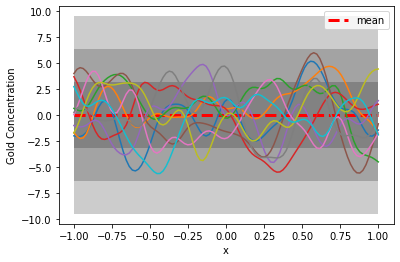

In [64]:
gp_plot(X_star,np.zeros_like(X_star),K)
plt.plot(X_star,Y_samp.squeeze().T)
plt.show()

Explore this procedure for a few different values of $\ell$ and $\sigma^2$.  **Write a few lines describing what changing these hyperparameters does**.  Another interesting covariance function is the exponential covariance
$$
k_{exp}(x,x') = \sigma^2 \exp \left( -\frac{|x-x'|}{\ell} \right).
$$
Repeat the above experiments using this covariance instead.  **How does this change alter the character of the sampled function?**

### GP Regression
We would now like to use these functions to regress on some data.  Imagine that we've sent out miners to assay the soil and they return with the following data

In [73]:
X = np.array([[-0.5,0.0,0.5,0.6,0.9]]).T
Y = np.array([[0.2,0.1,0.8,0.8,0.3]]).T

Compute the posterior mean and covariance of 
$$P(Y^*|X^*,X,Y).$$
The formulae for these are
$$
\mu_{post} = K(X^*,X) [K(X,X) + \sigma^2_{obs} I]^{-1} Y
$$
$$
K_{post} = K(X^*,X^*) - K(X^*,X) [K(X,X) + \sigma^2_{obs} I]^{-1} K(X,X^*)
$$
Begin with $\sigma^2 = 0.01$.

Using the plotting and sampling functions from above, plot the mean and marginal variance of these predictions as a function of space.  Include the observations on these plots as well.  Explore different values of $\sigma^2$, $\ell$ and discuss what you find to be values that fit the data well.  Try both squared-exponential and exponential covariance functions.  **Once you've decided on hyperparameters, write a few sentences describing the uncertainty and its relationship to the distance from the nearest datapoint.**    

In [76]:

def up(X_star,X,Y,sigma_obs,sigma2=10, l = 0.3):
    Up = k(X_star,X,sigma2=sigma2, l=l)@np.linalg.inv(k(X,X,sigma2=sigma2,l=l)+sigma_obs*np.identity(len(X)))@Y
    return Up
def kp(X_star,X,Y,sigma_obs,sigma2=10, l = 0.3):
    Kp = k(X_star,X_star,sigma2=sigma2,l=l)
    Kp-= k(X_star,X,sigma2=sigma2,l=l)@np.linalg.inv(k(X,X,sigma2=sigma2,l=l)+sigma_obs*np.identity(len(X)))@k(X,X_star,sigma2=sigma2,l=l)
    return Kp
Up=up(X_star, X, Y, 0.1)
Kp=kp(X_star, X, Y, 0.1)
print(Kp.shape)
print(Up.shape)

(100, 100)
(100, 1)


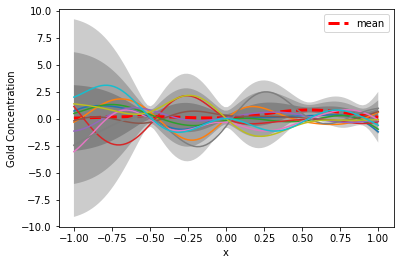

In [75]:
gp_plot(X,Up,Kp)
Y_sam = sample(np.zeros_like(X_star),Kp)
plt.plot(X_star,Y_sam.squeeze().T)
plt.show()

### Bonus Round (Optional)
Recreate a situation similar to the above, but in 2D (rather than 1D) spatial coordinates.  How does the process change (if at all)?




In [115]:
X = np.array([[-0.5,0.0,0.5,0.6,0.9],[0.7,0.2,0.1,0.3,-0.4]]).T
Y = np.array([[0.2,0.1,0.8,0.8,0.3]]).T


In [123]:
X_stars = np.vstack((X_star, X_star))
X_stars = X_stars.reshape(100,2)
K = k(X_stars,X)
K.shape

(100, 5)

In [129]:
Up=up(X_stars, X, Y, 0.1)
Kp=kp(X_stars, X, Y, 0.1)

(100, 100)

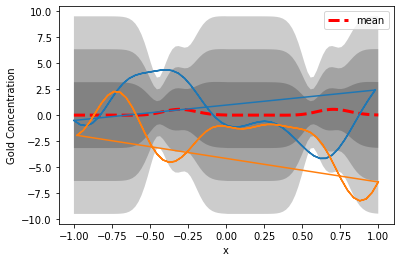

In [131]:
gp_plot(X,Up,Kp)
Y_sam = sample(np.zeros_like(X_stars),Kp, n_samples = 2)
plt.plot(X_stars,Y_sam.squeeze().T)
plt.show()